# contrasts_pond_core_properties

Notebook to injest ice core data from spreadsheets and compare bare ice and pond ice properties

@author: David Clemens-Sewall

In [2]:
import os
import glob
import re
import warnings
from datetime import datetime, timezone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from openpyxl import load_workbook

%matplotlib inline

In [3]:
# Paths
ic_data_root = os.path.join('..', 'data', 'ice_coring')

In [129]:
# Ice core data is very complicated, especially the vertical reference frame
# Define a class for representing ice cores
class IceCore:
    """
    Class representing data from an individual ice core.

    Attributes:
        station (str): Station number (1, 2, or 3) as a string.
        visit (str): Visit letter ([a-d]).
        file_path (str): Path to the xlsx file containing core data.
        core (str): Name of the core.
        site (str): Site name
        timestamp (datetime.datetime): Timestamp for the core.
        hi (float): Ice thickness (measured by a thickness gauge) in meters.
        draft (float): Draft (measured by a thickness gauge) in meters.
        length (float): Total core length in meters.
        freeboard (float): Freeboard (ice thickness - draft) in meters.
        snow_depths (array): Array of snow depths in meters.
        hs (float): Mean snow depth in meters.
        hp (float): Pond depth in meters.
        ponded (bool): Whether the ice was ponded.
        age (str): Sea ice age.
        data (Pandas.DataFrame): Dataframe containing data for this core.
        comments (Pandas.DataFrame): Dataframe containing comments for this core.
        units (dict): Mapping of variable names in self.data to units.
        variables (list): List of data variables that this ice core has.
    """
    
    def __init__(self, station, visit, file_path):
        """
        Initialize an IceCore object and load basic core metadata.

        Parameters:
            station (str): Station number (1, 2, or 3) as a string.
            visit (str): Visit letter ([a-d]).
            file_path (str): Path to the xlsx file containing core data.
        """
        # Store attributes
        self.station = station
        self.visit = visit
        self.file_path = file_path

        # Open excel workbook
        wb = load_workbook(file_path, read_only=True, data_only=True)
        ws_core = wb['metadata-core']
        ws_coring = wb['metadata-coring']

        # Get the core name from the workbook and check that it matches the filename
        core_fn = os.path.basename(file_path)[:-5]
        core_wb = ws_core['C1'].value
        if core_fn != core_wb:
            warnings.warn(f"Core name from filename does not match workbook, using core name from file: {core_fn}",
                          category=RuntimeWarning)
        self.core = core_fn
        self.site = ws_coring['C4'].value

        ## Get basic parameters
        # time
        if ws_core['D2'].value == 'UTC':
            tzinfo = timezone.utc
        else:
            raise RuntimeError('Timezone is not UTC, need to implement support for other timezones')
        date = ws_core['C2'].value
        time = ws_core['C3'].value
        if time is None:
            time = ws_coring['C13'].value
        self.timestamp = datetime.combine(date, time, tzinfo=tzinfo)
        # ice measurements
        self.hi = ws_core['C7'].value
        self.draft = ws_core['C8'].value
        self.freeboard = ws_core['C9'].value
        self.length = ws_core['C10'].value
        if self.length is None:
            raise RuntimeError(f"{self.core} is missing core length")
        # Account for potential missing core data
        if self.hi is None:
            warnings.warn(f"{self.core} is missing ice thickness, using core length",
                          category=RuntimeWarning)
            self.hi = self.length
        if (self.draft is None) and (self.freeboard is None):
            warnings.warn(f"{self.core} is missing freeboard and draft",
                         category=RuntimeWarning)
        elif self.freeboard is None:
            self.freeboard = self.hi - self.draft
        elif self.draft is None:
            self.draft = self.hi - self.freeboard
        self.age = ws_coring['C20'].value
        # snow measurements
        for value in ws_coring.iter_rows(min_row=16, max_row=16, min_col=3, max_col=8, values_only=True):
            self.snow_depths = np.array(value, dtype=float)
        if np.isnan(self.snow_depths).all():
            self.hs = 0
        else:
            self.hs = np.nanmean(self.snow_depths)
        # pond measurements
        self.hp = ws_coring['C19'].value
        if self.hp is None:
            self.ponded = False
            self.hp = 0
        else:
            self.ponded = True

        ## Initialize the data and comments dataframes
        idx = pd.MultiIndex.from_tuples([], names=('variable', 'depth_top', 'depth_bottom', 'depth_center'))
        self.data = pd.DataFrame(columns=['value'], index=idx)
        self.comments = pd.DataFrame(columns=['description', 'comment'], index=idx)
        self.units = {}
        self.variables = []
        wb.close()

    def load_salinity(self):
        """Loads salinity data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['SALO18']

        # If there is no data at all in the temperature sheet, return
        if ws['A5'].value is None:
            return
        # Read in values
        ls_d_t = []
        ls_d_b = []
        ls_s = []
        ls_c = []
        for row in ws.iter_rows(min_row=5, min_col=1, max_col=14):
            d_t = row[0].value
            if d_t is None:
                break
            else:
                ls_d_t.append(d_t)
                ls_d_b.append(row[1].value)
                ls_s.append(row[4].value)
                ls_c.append(row[13].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'salinity',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'value': ls_s})
        df_data_temp['depth_center'] = (df_data_temp['depth_top'] + df_data_temp['depth_bottom'])/2.0
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'salinity',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp['depth_center'] = (df_comm_temp['depth_top'] + df_comm_temp['depth_bottom'])/2.0
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        self.data = pd.concat([self.data, df_data_temp])
        self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('salinity')
        self.units['salinity'] = ws['E4'].value
        wb.close()

    def load_densimetry(self):
        """Loads densimetry data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['Density-densimetry']

        # If there is no data at all in the temperature sheet, return
        if ws['A4'].value is None:
            return
        # Read in values
        ls_d_t = []
        ls_d_b = []
        ls_r = []
        ls_c = []
        for row in ws.iter_rows(min_row=4, min_col=1, max_col=8):
            d_t = row[0].value
            if d_t is None:
                break
            else:
                ls_d_t.append(d_t)
                ls_d_b.append(row[1].value)
                ls_r.append(row[6].value)
                ls_c.append(row[7].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'density',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'value': ls_r})
        df_data_temp['depth_center'] = (df_data_temp['depth_top'] + df_data_temp['depth_bottom'])/2.0
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'density',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp['depth_center'] = (df_comm_temp['depth_top'] + df_comm_temp['depth_bottom'])/2.0
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        self.data = pd.concat([self.data, df_data_temp])
        self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('density')
        self.units['density'] = ws['G3'].value
        wb.close()

    def load_temperature(self):
        """Loads temperature data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['TEMP']

        # If there is no data at all in the temperature sheet, return
        if ws['A4'].value is None:
            return
        # Read in values
        ls_d_c = []
        ls_t = []
        ls_c = []
        for row in ws.iter_rows(min_row=4, min_col=1, max_col=3):
            d_c = row[0].value
            if d_c is None:
                break
            else:
                ls_d_c.append(d_c)
                ls_t.append(row[1].value)
                ls_c.append(row[2].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'temperature',
                                     'depth_top': np.nan,
                                     'depth_bottom': np.nan,
                                     'depth_center': ls_d_c,
                                     'value': ls_t})
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'temperature',
                                     'depth_top': np.nan,
                                     'depth_bottom': np.nan,
                                     'depth_center': ls_d_c,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        self.data = pd.concat([self.data, df_data_temp])
        self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('temperature')
        self.units['temperature'] = ws['B3'].value
        wb.close()

    def plot_profile(self, ax, variable, z_ref='ice top', z_scale='absolute',
                     kind='center', linestyle='solid', color = 'C0',
                    markersize=3):
        """
        Plots a profile of a single variable from the ice core following various conventions

        Parameters:
            ax (Matplotlib Axes): Axes to plot on.
            variable (str): Variable to plot, must be in self.data
            z_ref (str): Vertical reference for profile, must be one of ['ice top',
                'sea surface', 'pond surface']. The default is 'ice top'.
            z_scale (str): How to scale z values, must be one of ['absolute', 
                'relative']. The default is 'absolute'.
            kind (str): Whether to plot values at the 'center' of ice segments
                or as a line spanning entire segment ('segment') the default is 'center'.
            linestyle (str): Line style for line.
            color (color for Matplotlib): Line color.
            markersize (float): Marker size

        Returns:
            Handle from matplotlib object.
        """
        
        # z_ref_dict for converting z_ref into z values
        z_ref_dict = {'ice top': 0,
                      'sea surface': self.freeboard,
                      'pond surface': -self.hp
                     }
        z_unit_dict = {'absolute': 'm',
                       'relative': '1',
                      }
        # Get data
        df_plot = self.data.query('variable == @variable').reset_index()
        # Adjust for z-reference
        df_plot['z_t'] = z_ref_dict[z_ref] - df_plot['depth_top']
        df_plot['z_b'] = z_ref_dict[z_ref] - df_plot['depth_bottom']
        df_plot['z_c'] = z_ref_dict[z_ref] - df_plot['depth_center']
        # If scale is relative, adjust for relative vertical position
        if z_scale == 'relative':
            if z_ref == 'pond surface':
                z_top = 0
                z_bottom = -self.hp - self.length
            else:
                z_top = z_ref_dict[z_ref]
                z_bottom = z_top - self.length
            df_plot['z_t'] = (df_plot['z_t'] - z_bottom) / (z_top - z_bottom)
            df_plot['z_b'] = (df_plot['z_b'] - z_bottom) / (z_top - z_bottom)
            df_plot['z_c'] = (df_plot['z_c'] - z_bottom) / (z_top - z_bottom)
        elif z_scale != 'absolute':
            raise RuntimeError('invalid value for z_scale')
        
        # Plot values
        if kind == 'segment':
            h = ax.vlines(df_plot['value'], df_plot['z_b'], df_plot['z_t'],
                      colors=color, linestyles=linestyle, label=self.core)
            ax.plot(df_plot['value'], df_plot['z_b'], color=color,
                    marker='o', linestyle='none', label=None,
                   markersize=markersize)
            ax.plot(df_plot['value'], df_plot['z_t'], color=color,
                    marker='o', linestyle='none', label=None,
                   markersize=markersize)
        elif kind == 'center':
            h = ax.plot(df_plot['value'], df_plot['z_c'],
                        color=color, linestyle=linestyle, label=self.core,
                        marker='o', markersize=markersize)
        else:
            raise RuntimeError('invalid value for kind')
        
        ax.set_ylabel(f'{z_scale} height from {z_ref} ({z_unit_dict[z_scale]})')
        ax.set_xlabel(f'{variable} ({self.units[variable]})')

        return h

In [130]:
# Load all ice core data
stations = ['1', '2', '3']
visits = ['b', 'c', 'd']

# Load each core into a dataframe
ls_s = []
ls_v = []
ls_name = []
ls_icecore = []
for station in stations:
    for visit in visits:
        filepaths = glob.glob(os.path.join(ic_data_root, f"IceStation{station}{visit}", '**', '[!~]*.xlsx'))
        for fp in filepaths:
            # load core properties
            ic = IceCore(station, visit, fp)
            # Load data if present
            ic.load_temperature()
            ic.load_salinity()
            ic.load_densimetry()
            # Append to lists
            ls_s.append(station)
            ls_v.append(visit)
            ls_name.append(ic.core)
            ls_icecore.append(ic)

df_cores = pd.DataFrame({'station': ls_s,
                         'visit': ls_v,
                         'name': ls_name,
                         'core': ls_icecore})
df_cores = df_cores.set_index(['station', 'visit', 'name'])

/tmp/ipykernel_103/555303250.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])
/tmp/ipykernel_103/555303250.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])
/tmp/ipykernel_103/555303250.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result

In [105]:
df_cores

core
station visit name                                                                                           
1       b     20250726-PS149_21-1-SI_corer_9cm-016-FYI-T          <__main__.IceCore object at 0x7f09ff2ef650>
              20250726-PS149_21-1-SI_corer_9cm-017-FYI-REP        <__main__.IceCore object at 0x7f09ff164a70>
              20250726-PS149_21-1-SI_corer_9cm-018-FYI-SALO18     <__main__.IceCore object at 0x7f09fe466840>
              20250726-PS149_21-1-SI_corer_9cm-019-FYI-RHO        <__main__.IceCore object at 0x7f09fe42ede0>
              20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T     <__main__.IceCore object at 0x7f0a00f85a00>
              20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-S...  <__main__.IceCore object at 0x7f0a00dc52b0>
              20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO   <__main__.IceCore object at 0x7f09fe219940>
              20250727-PS149_21-1-SI_corer_9cm-023-FYI-melt_p...  <__main__.IceCore object at 0x7f0a01fe8a40>
        c     20250809-PS149_32-1-SI_corer_9cm-016-FYI-SALO18     <__main__.IceCore object at 0x7f09ff2ec9e0>
              20250809-PS149_32-1-SI_corer_9cm-017-FYI-T          <__main__.IceCore object at 0x7f09ff1b3ce0>
              20250809-PS149_32-1-SI_corer_9cm-018-FYI-REP        <__main__.IceCore object at 0x7f0a0072c710>
              20250809-PS149_32-1-SI_corer_9cm-019-FYI-RHO        <__main__.IceCore object at 0x7f09fd7f7290>
              20250810-PS149_32-1-SI_corer_9cm-020-FYI-melt_p...  <__main__.IceCore object at 0x7f0a007057c0>
2       b     20250730-PS149_25-1-SI_corer_9cm-016-FYI-SALO18     <__main__.IceCore object at 0x7f09fe41b170>
              20250730-PS149_25-1-SI_corer_9cm-017-FYI-T          <__main__.IceCore object at 0x7f09fd2173b0>
              20250730-PS149_25-1-SI_corer_9cm-018-FYI-REP        <__main__.IceCore object at 0x7f09fd10d160>
              20250730-PS149_25-1-SI_corer_9cm-019-FYI-RHO        <__main__.IceCore object at 0x7f09fe548080>
              20250730-PS149_25-1-SI_corer_9cm-020-SMYI-T         <__main__.IceCore object at 0x7f09fd261580>
              20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO       <__main__.IceCore object at 0x7f09fd985160>
              20250730-PS149_25-1-SI_corer_9cm-022-SMYI-REP       <__main__.IceCore object at 0x7f09fe1a8170>
              20250731-PS149_25-1-SI_corer_9cm-023-FYI-S-melt...  <__main__.IceCore object at 0x7f09fccca030>
              20250731-PS149_25-1-SI_corer_9cm-024-FYI-NE-mel...  <__main__.IceCore object at 0x7f0a00e34740>
        c     20250812-PS149_36-1-SI_corer_9cm-016-FYI-SALO18     <__main__.IceCore object at 0x7f0a00e303b0>
              20250812-PS149_36-1-SI_corer_9cm-017-FYI-T          <__main__.IceCore object at 0x7f09fd10d370>
              20250812-PS149_36-1-SI_corer_9cm-018-FYI-REP        <__main__.IceCore object at 0x7f09fd115160>
              20250812-PS149_36-1-SI_corer_9cm-019-FYI-RHO        <__main__.IceCore object at 0x7f09fefb6810>
              20250813-PS149_36-1-SI_corer_9cm-020-FYI-T3-mel...  <__main__.IceCore object at 0x7f09feecd2b0>
              20250814-PS149_36-1-SI_corer_9cm-021-SYI-SALO18     <__main__.IceCore object at 0x7f09fd8ee720>
        d     20250823-PS149_46-1-SI_corer_9cm-016-FYI-SALO18     <__main__.IceCore object at 0x7f09fe1a7740>
              20250823-PS149_46-1-SI_corer_9cm-017-FYI-T          <__main__.IceCore object at 0x7f09fe749b50>
              20250823-PS149_46-1-SI_corer_9cm-018-FYI-REP        <__main__.IceCore object at 0x7f0a00711400>
              20250823-PS149_46-1-SI_corer_9cm-019-FYI-RHO        <__main__.IceCore object at 0x7f09fd341940>
              20250823-PS149_46-1-SI_corer_9cm-020-FYI-T3-mel...  <__main__.IceCore object at 0x7f09fe218c50>
3       b     20250804-PS149_30-1-SI_corer_9cm-016-SYI-SALO18     <__main__.IceCore object at 0x7f09fcb03770>
              20250804-PS149_30-1-SI_corer_9cm-017-SYI-T          <__main__.IceCore object at 0x7f09fd0f3980>
              20250804-PS149_30-1-S

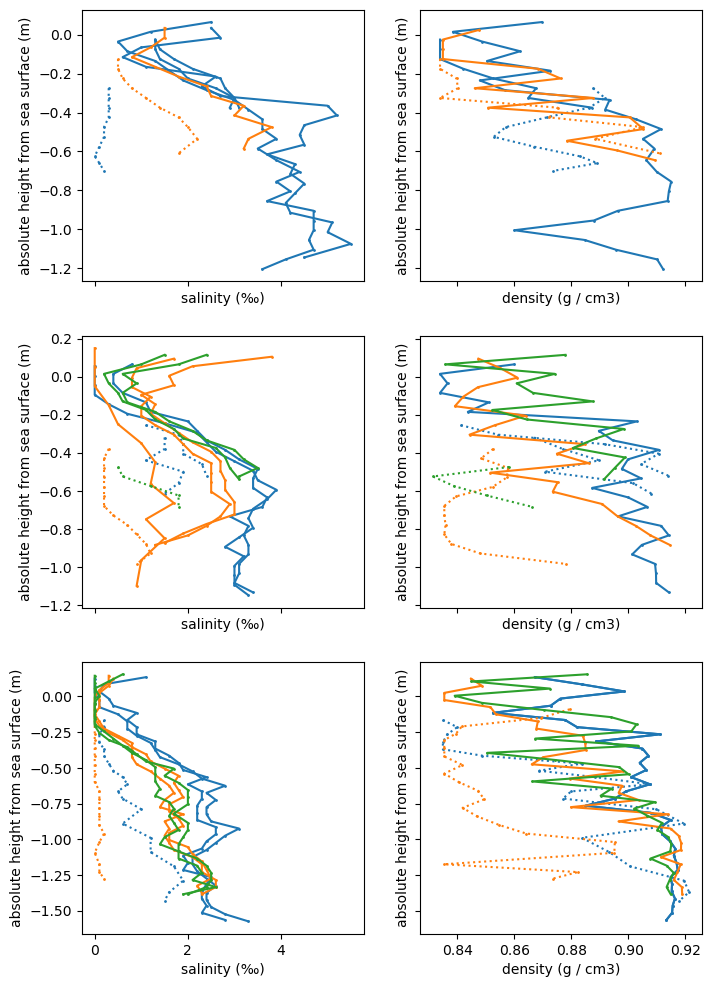

In [143]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(8, 12))

stations = ['1', '2', '3']

color_dict = {'b': 'C0',
              'c': 'C1',
              'd': 'C2',
             }

kind = 'center'
markersize = 1

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dotted'
        else:
            ls = 'solid'
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref='sea surface',
                            color=color_dict[visit], linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref='sea surface',
                            color=color_dict[visit], linestyle=ls,
                           kind=kind, markersize=markersize)


In [141]:
tup[3]

'20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO'

In [122]:
# Testing class
station = '1'
visit = 'b'

filepaths = glob.glob(os.path.join(ic_data_root, f"IceStation{station}{visit}", '**', '[!~]*.xlsx'))

In [123]:
filepaths

['../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-016-FYI-T.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-017-FYI-REP.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-018-FYI-SALO18.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-019-FYI-RHO.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-SALO18.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO.xlsx',
 '../data/ice_coring/IceStation1b/27jul2025coring_melt_pond/20250727-PS149_21-1-SI_corer_9cm-023-FYI-melt_pond-RHO.xlsx']

In [124]:
self = IceCore(station, visit, filepaths[7])

In [125]:
self.load_salinity()

/tmp/ipykernel_103/3997622715.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])


In [126]:
self.load_densimetry()

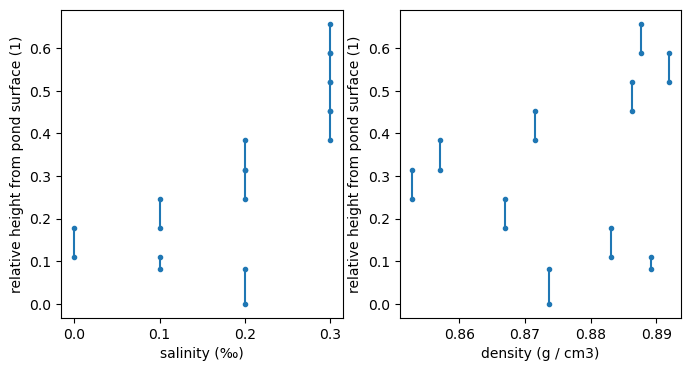

In [128]:
# Test plotting
f, axs = plt.subplots(1, 2, figsize=(8, 4))

z_ref = 'pond surface'#'sea surface'#'ice top'#
z_scale = 'relative'#'absolute'#
kind = 'segment'#'center'
markersize = 3

ax = axs[0]
variable = 'salinity'
self.plot_profile(ax, variable, z_ref=z_ref, z_scale=z_scale, kind=kind,
                 markersize=markersize)

ax = axs[1]
variable = 'density'
self.plot_profile(ax, variable, z_ref=z_ref, z_scale=z_scale, kind=kind,
                 markersize=markersize)

Text(0.5, 0, 'salinity (‰)')

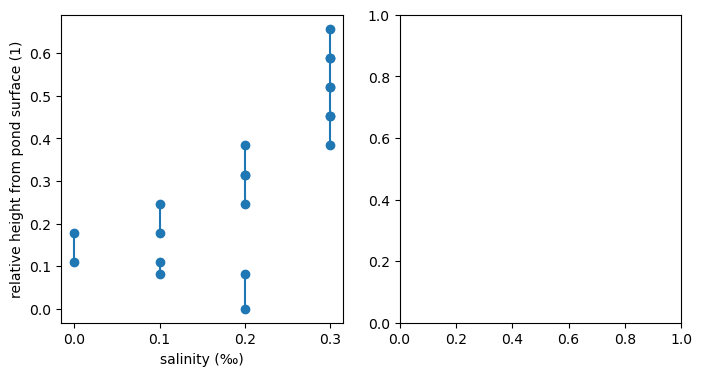

In [93]:
# Look into plotting


linestyle = 'solid'
color = 'C0'

# z_ref_dict for converting z_ref into z values
z_ref_dict = {'ice top': 0,
              'sea surface': self.freeboard,
              'pond surface': -self.hp
             }
z_unit_dict = {'absolute': 'm',
               'relative': '1',
              }
# Get data
df_plot = self.data.query('variable == @variable').reset_index()
# Adjust for z-reference
df_plot['z_t'] = z_ref_dict[z_ref] - df_plot['depth_top']
df_plot['z_b'] = z_ref_dict[z_ref] - df_plot['depth_bottom']
df_plot['z_c'] = z_ref_dict[z_ref] - df_plot['depth_center']
# If scale is relative, adjust for relative vertical position
if z_scale == 'relative':
    if z_ref == 'pond surface':
        z_top = 0
        z_bottom = -self.hp - self.length
    else:
        z_top = z_ref_dict[z_ref]
        z_bottom = z_top - self.length
    df_plot['z_t'] = (df_plot['z_t'] - z_bottom) / (z_top - z_bottom)
    df_plot['z_b'] = (df_plot['z_b'] - z_bottom) / (z_top - z_bottom)
    df_plot['z_c'] = (df_plot['z_c'] - z_bottom) / (z_top - z_bottom)
elif z_scale != 'absolute':
    raise RuntimeError('invalid value for z_scale')

# Plot values
if kind == 'segment':
    h = ax.vlines(df_plot['value'], df_plot['z_b'], df_plot['z_t'],
              colors=color, linestyles=linestyle, label=self.core)
    ax.plot(df_plot['value'], df_plot['z_b'], color=color,
            marker='o', linestyle='none', label=None)
    ax.plot(df_plot['value'], df_plot['z_t'], color=color,
            marker='o', linestyle='none', label=None)
elif kind == 'center':
    h = ax.plot(df_plot['value'], df_plot['z_c'],
                color=color, linestyle=linestyle, label=self.core,
                marker='o')
else:
    raise RuntimeError('invalid value for kind')

ax.set_ylabel(f'{z_scale} height from {z_ref} ({z_unit_dict[z_scale]})')
ax.set_xlabel(f'{variable} ({self.units[variable]})')

In [ ]:
z_top =

In [75]:
self.hp

0.25

In [57]:
test.hs

0

In [58]:
test.load_salinity()

/tmp/ipykernel_103/1578580064.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])


In [61]:
test.units

{'salinity': '‰', 'density': 'g / cm3'}

In [62]:
test.age

'FY (first year)'

In [63]:
test.hp

0.25

In [64]:
test.data

value
variable depth_top depth_bottom depth_center          
salinity 0.0       0.05         0.025         0.300000
         0.05      0.1          0.075         0.300000
         0.1       0.15         0.125         0.300000
         0.15      0.2          0.175         0.300000
         0.2       0.25         0.225         0.200000
         0.25      0.3          0.275         0.200000
         0.3       0.35         0.325         0.100000
         0.35      0.4          0.375         0.000000
         0.4       0.42         0.41          0.100000
         0.42      0.48         0.45          0.200000
density  0.0       0.05         0.025         0.887701
         0.05      0.1          0.075         0.891841
         0.1       0.15         0.125         0.886287
         0.15      0.2          0.175         0.871442
         0.2       0.25         0.225         0.857036
         0.25      0.3          0.275         0.852846
         0.3       0.35         0.325         0.866869
         0.35      0.4          0.375         0.883019
         0.4       0.42         0.41          0.889191
         0.42      0.48         0.45          0.873695

In [52]:
test.hi

0.8

In [53]:
test.length

0.48

In [54]:
test.comments

description       comment
variable    depth_top depth_bottom depth_center                          
temperature 0.0       0.05         0.025                             None
            0.05      0.1          0.075                             None
            0.1       0.15         0.125                             None
            0.15      0.2          0.175                             None
            0.2       0.25         0.225                             None
            0.25      0.3          0.275                             None
            0.3       0.35         0.325                             None
            0.35      0.4          0.375                             None
            0.4       0.42         0.41                      platelet ice
            0.42      0.48         0.45                      false bottom